#### I. Referencias consultadas

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
name_code = "03_Code";

In [2]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [3]:
grid_type="simple_line";                            # tipo de grilla
ΔxH=1.0/800.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0232617s, CPU 0.022526s)
Info    : 40001 nodes 40002 elements
Info    : Writing '../outputs/03_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/03_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/03_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 40001 nodes
Info    : 40002 elements
Info    : Done reading '../outputs/03_Code/models/simple_line_01.msh'


In [4]:
x,pts=space_coord(dom_1D,ΔxH);

## 3. Eigenvalue method

La idea acá es resolver el problema de autovalores para el hamiltoniano $\hat {h}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuación de Sturm-Liouville con parámetros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q(x) = V_\binom{electron}{nucleus}(x)\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales que serán de la forma:

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}( u_{1} ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    a_{2}( u_{2} ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q( x)( v_{2} u_{2})] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}( u_{1} ,v_{1}) +a_{2}( u_{2} ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( v_{2} u_{2}) d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

In [5]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);

R=2.0;R₁=-5.0;R₂=5.0;Rc=1.5;Rf=1.5; # parameters

pₕ,qₕ,rₕ=eigenvalue_problem_functions((R,R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_1D")
aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D;switch_potential = "Electron_Nuclear_Potential_1D");

Set Electron-Nuclear potential with fixed R


Showing interaction potential plots

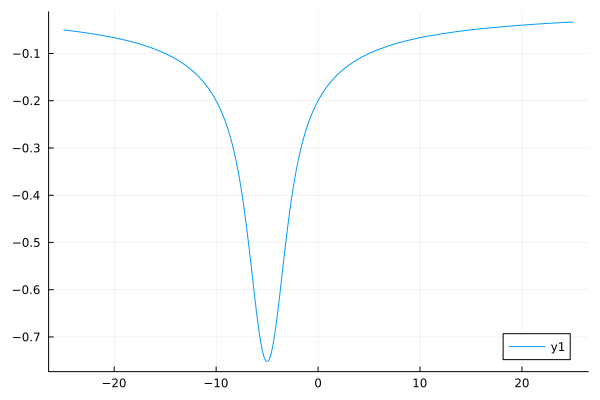

In [ ]:
plt1=plot();
plt2=plot!(plt1,x,Aprox_Coulomb_Potential.(x,R₁,Rc));

display(plt2)

Construimos el problema de autovalores, con parámetros específicos de resolución

In [6]:
nevₕ=8; # debe ser múltiplo de 2
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none);

Resolvermos el problema, para obtener autovalores y autoestados

In [7]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [8]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,convert(Int32,probₕ_1D.nev/2));

for i in 1:2:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    fₕre_1D,fₕim_1D=fₕ_1D;
    ϕₕreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(fₕre_1D+im*fₕim_1D,Uₕreim_1D);
end

Verificamos la normalización de los autoestados, para ello usando la función anterior y deberíamos obtener resultados cercanos a la unidad

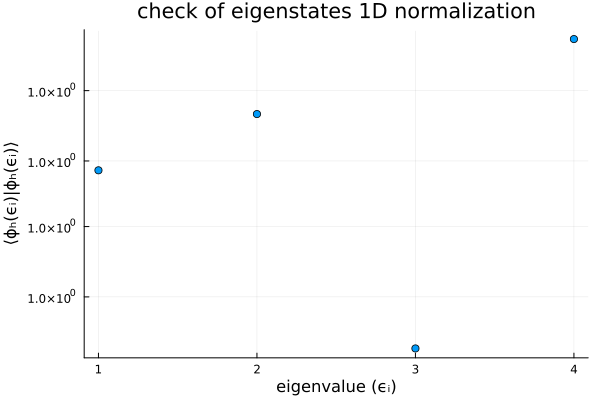

GKS: Possible loss of precision in routine SET_WINDOW


In [9]:
plotting=true
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    plot₁=plot!(title="check of eigenstates 1D normalization")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

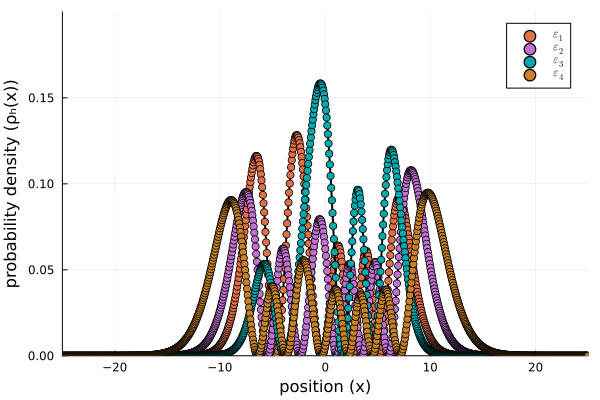

In [10]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,0.20),xlim=(-25,25))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,0.20),xlim=(-25,25))
        plot1=plot!(xlabel="position (x)",ylabel="probability density (ρₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_FWP_individual.pdf");
end

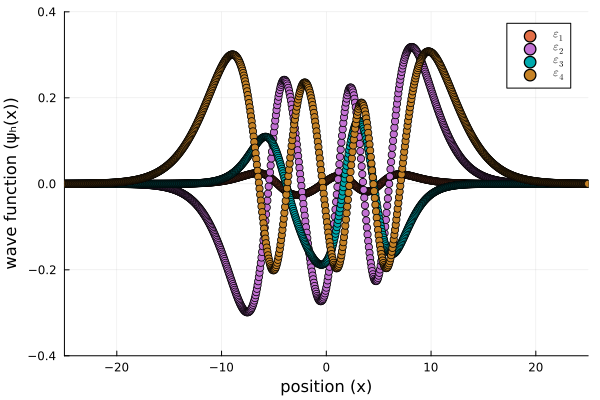

In [11]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        ψₕreim_1D=real(ϕₕreim_1D[i].(pts))
        plot1=plot!(x,ψₕreim_1D,label="",lw=2,lc=:"black",ylim=(-0.4,0.4),xlim=(-25,25))
        plot1=scatter!(x,ψₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(-0.4,0.4),xlim=(-25,25))
        plot1=plot!(xlabel="position (x)",ylabel="wave function (ψₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"eigenstates_FWP_individual.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

In [12]:
ϵₕ₁re_1D=ϵₕ_1D[1:2:end];    # vector de autovalores (SIN DEGENERACIÓN)

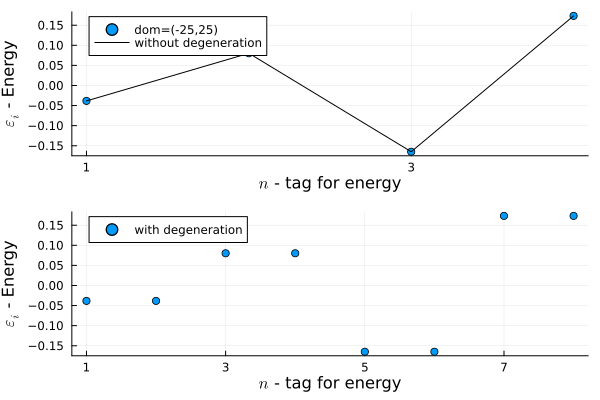

In [13]:
plotting=true

if plotting
    plot1=scatter([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Calculus of differential Shannon entropy


Definition: The differential entropy $h(X)$ of a continuous variable X with density f(x) is defined as

\begin{align}
    h(X)=-\int_{S}f(x)log\left[ f(x) \right]dx
\end{align}

where $S$ is the support set of the random variable.
As in the discrete case, the differential entropy depends only on the probability density of the random variable, and therefore the differential entropy is sometimes written as $h(f)$ rather than $h(X)$.

Ref.: Cover, T.M., 1999. Elements of information theory. John Wiley & Sons.

In [14]:
S=TimeIndependet_Diff_Shannon_Entropy_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D)

4-element Vector{Float64}:
 0.013293194499690957
 0.015953689462457354
 0.010986784370153274
 0.018433646763652282

utils links:

+ https://arxiv.org/pdf/1910.01412.pdf
+ https://docs.sciml.ai/Gridap/v0.9/Fields/#Gridap.Fields.%E2%88%87

## 4. Resolve Time-Dependent Schrödinger equation (time evolution)

We can write time evolution as:

\begin{align}
    \ket{\psi ( t)} =\sum _{n=1}^{\infty } c_{n}\exp\left(\frac{-iE_{n} t}{\hbar }\right)\ket{\phi _{n}} =e^{\left(\tfrac{-i}{\hbar } t\right)}\left( c_{1} e^{E_{1}}\ket{\phi _{n}} +c_{2} e^{E_{2}}\ket{\phi _{2}} +\dotsc +c_{n} e^{E_{n}}\ket{\phi _{n}}\right)
\end{align}

Then  knowing the Hamiltonian $\hat {H}(x)$ eigenstates we can evolve the system. To do this we must first find how the initial state descomposes into the eigenstates basis of $\hat {H}(x)$.

## 4.1 Create initial state

In [15]:
function gaussian_factor(R,R₀,β)
    return exp(-β*pow((R-R₀),2));
end

function create_initial_state_1D(ϕₙ,n,TrialSpace,dΩ,R,R₀,β)
    𝛹ₓ₀=interpolate_everywhere(exp(-β*pow((R-R₀),2))*ϕₙ[n],TrialSpace);
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_1D (generic function with 1 method)

In [16]:
𝛹ₓ₀=create_initial_state_1D(ϕₕreim_1D,1,Uₕreim_1D,dΩ_1D,R,-1.5,3.57);

In [17]:
t_start=0.0;t_end=500#8269;                      # tiempos adimensionales inicial y final
num_steps=t_end-1;                           # number of time steps or number of points  
n_int_save=round(Int, (num_steps-1)/20);     # Intervals where data is saved n_int_save=n_inf/20=(num_steps-1)/20
Δt=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

@printf("Δx=%.6f\nΔt=%.6f\n#steps=%.d",ΔxH,Δt,num_steps)

time_vec=[t_start+(i-1)*Δt for i in 1:n_int_save:num_steps];

Δx=0.001250
Δt=1.004016
#steps=499

In [18]:
𝛹ₓₜ=evolution_schrodinger_1D(𝛹ₓ₀,ϕₕreim_1D,ϵₕ₁re_1D,Uₕreim_1D,dΩ_1D,time_vec);

┌ Info: Saved animation to /tmp/jl_XwFerA9ohu.gif
└ @ Plots /home/mendez/.julia/packages/Plots/bMtsB/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_XwFerA9ohu.gif")
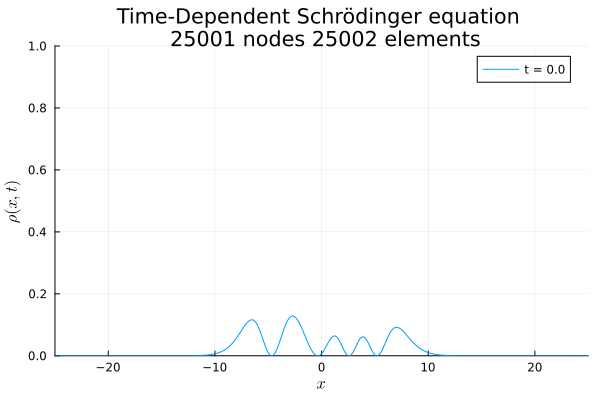

In [19]:
anim₁ = @animate for i in 1:length(time_vec)
    ρₕreim_1D=real(conj(𝛹ₓₜ[i].(pts)).*𝛹ₓₜ[i].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    plot(x[:],ρₕreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-25,25))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-25,25))
end

gif(anim₁, fps = 10)